# 手写实现MLP分类器

In [1]:
import tensorflow as tf#引入tensorflow只是为了导入mnist数据集
import numpy as np
import matplotlib.pyplot as plt

## 定义多层神经网络

In [2]:
class MultiLayerNet:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.params = {}
        self.activation = activation
        
        # 初始化权重和偏置
        self.__init_weight()
    
    def __init_weight(self):
        sizes = [self.input_size] + self.hidden_sizes + [self.output_size]
        for i in range(1, len(sizes)):
            self.params['W' + str(i)] = np.random.randn(sizes[i-1], sizes[i]) / np.sqrt(sizes[i-1])
            self.params['b' + str(i)] = np.zeros(sizes[i])
    
    def __relu(self, x):
        return np.maximum(0, x)
    
    def __sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def __tanh(self, x):
        return np.tanh(x)
    
    def __softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def __forward(self, x):
        activations = {}
        activations['A0'] = x
        for i in range(1, len(self.hidden_sizes)+2):
            W = self.params['W' + str(i)]
            b = self.params['b' + str(i)]
            Z = np.dot(activations['A' + str(i-1)], W) + b
            if i == len(self.hidden_sizes)+1:
                activations['A' + str(i)] = self.__softmax(Z)
            else:
                if self.activation == 'relu':
                    activations['A' + str(i)] = self.__relu(Z)
                elif self.activation == 'sigmoid':
                    activations['A' + str(i)] = self.__sigmoid(Z)
                elif self.activation == 'tanh':
                    activations['A' + str(i)] = self.__tanh(Z)
        return activations
    
    def loss(self, x, t, l1=0, l2=0):
        y = self.__forward(x)['A' + str(len(self.hidden_sizes)+1)]
        cross_entropy = -np.sum(t * np.log(y + 1e-7)) / len(x)
        regularization = 0
        for i in range(1, len(self.hidden_sizes)+2):
            W = self.params['W' + str(i)]
            regularization += l1 * np.sum(np.abs(W)) + l2 * np.sum(W ** 2)
        return cross_entropy + regularization
    
    def accuracy(self, x, t):
        y = self.__forward(x)['A' + str(len(self.hidden_sizes)+1)]
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def gradient(self, x, t, l1=0, l2=0):
        activations = self.__forward(x)
        grads = {}
        
        delta = (activations['A' + str(len(self.hidden_sizes)+1)] - t) / len(x)
        for i in range(len(self.hidden_sizes)+1, 0, -1):
            grads['W' + str(i)] = np.dot(activations['A' + str(i-1)].T, delta) + l1 * np.sign(self.params['W' + str(i)]) + 2 * l2 * self.params['W' + str(i)]
            grads['b' + str(i)] = np.sum(delta, axis=0)
            if i > 1:
                W = self.params['W' + str(i)]
                if self.activation == 'relu':
                    delta = np.dot(delta, W.T) * (activations['A' + str(i-1)] > 0)
                elif self.activation == 'sigmoid':
                    delta = np.dot(delta, W.T) * activations['A' + str(i-1)] * (1 - activations['A' + str(i-1)])
                elif self.activation == 'tanh':
                    delta = np.dot(delta, W.T) * (1 - np.square(activations['A' + str(i-1)]))
        return grads

## 主程序

0.1041 0.1015
0.8659166666666667 0.8663
0.8728833333333333 0.8713
0.8734166666666666 0.8722
0.8734666666666666 0.8722
0.8734833333333333 0.8722
0.8734833333333333 0.8722
0.8734833333333333 0.8722
0.8734833333333333 0.8722
0.8734833333333333 0.8722


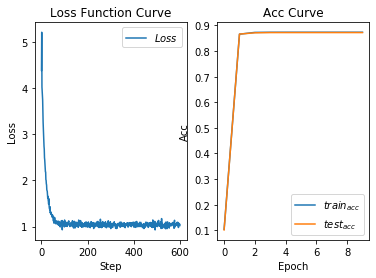

In [3]:
# 读入数据
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 设置神经网络参数
input_size = 784
hidden_sizes = [50,45,50]  # 用户可以指定每个隐藏层的神经元数
output_size = 10
activation = 'relu'  # 可选: 'relu', 'sigmoid', 'tanh'

# 初始化神经网络模型
network = MultiLayerNet(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, activation=activation)

# 设置超参数
iters_num = 600 #指定的总迭代次数
train_size = x_train.shape[0]
batch_size = 512
learning_rate = 0.05
decay_rate = 0.95  # 学习率衰减率
optimizer = 'adam'  # 可选: 'momentum', 'adam', 'adagrad'
momentum = 0.9  # momentum 优化算法的动量参数
beta1 = 0.9  # Adam 优化算法的一阶矩估计参数
beta2 = 0.999  # Adam 优化算法的二阶矩估计参数
epsilon = 1e-8  # 避免除零错误的小数值

# 正则化参数
l1 = 0.001
l2 = 0.001

train_loss_list = []
train_acc_list = []
test_acc_list = []

#iter_per_epoch = max(train_size / batch_size, 1)
iter_per_epoch=60 #每个 epoch 中的迭代次数

# 初始化优化器参数
m = {}
v = {}
for key in network.params.keys():
    m[key] = np.zeros_like(network.params[key])
    v[key] = np.zeros_like(network.params[key])

# 训练
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]

    grad = network.gradient(x_batch, y_batch, l1, l2)
    
    # 更新参数
    if optimizer == 'momentum':
        for key in network.params.keys():
            m[key] = momentum * m[key] + learning_rate * grad[key]
            network.params[key] -= m[key]
    elif optimizer == 'adam':
        for key in network.params.keys():
            m[key] = beta1 * m[key] + (1 - beta1) * grad[key]
            v[key] = beta2 * v[key] + (1 - beta2) * (grad[key] ** 2)
            m_hat = m[key] / (1 - beta1 ** (i+1))
            v_hat = v[key] / (1 - beta2 ** (i+1))
            network.params[key] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    elif optimizer == 'adagrad':
        for key in network.params.keys():
            v[key] += grad[key] ** 2
            network.params[key] -= learning_rate * grad[key] / (np.sqrt(v[key]) + epsilon)

    loss = network.loss(x_batch, y_batch, l1, l2)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, y_train)
        test_acc = network.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

    # 学习率衰减
    learning_rate *= decay_rate

# 绘制 loss 曲线
plt.subplot(1, 2, 1)
plt.title('Loss Function Curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(train_loss_list, label="$Loss$")
plt.legend()

# 绘制 Accuracy 曲线
plt.subplot(1, 2, 2)
plt.title('Acc Curve')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.plot(train_acc_list, label="$train_{acc}$")
plt.plot(test_acc_list, label="$test_{acc}$")
plt.legend()
plt.show()